In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from scipy.stats import uniform, maxwell


from matplotlib.colors import LinearSegmentedColormap


%matplotlib inline

# set some global options\n",
plt.rcParams['figure.figsize'] = (8,7)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['ytick.minor.size'] = 20
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 20

class Constants():
    def __init__(self):
        self.msun = 1.989e33
        self.rsun = 6.955e10
        self.G  = 6.674e-8
        self.yr = 3.1536e7
        self.day = 60*60*24
        self.h  = 6.6260755e-27
        self.kB = 1.380658e-16
        self.mp = 1.6726219e-24
        self.me = 9.10938356e-28
        self.c  = 2.99792458e10
        self.pc = 3.085677581e18
        self.au = 1.496e13
        self.q = 4.8032068e-10
        self.eV = 1.6021772e-12
        self.sigmaSB = 5.67051e-5
        self.sigmaT = 6.6524e-25

        # print ("Constants defined...")                                                                        
        return None

c = Constants()

In [2]:

def finalorb(beta,v,theta,phi):  #calculate final orbit from beta=M_f/M_i, v=v_kick/v_orb, theta and phi=radians
    
    alpha = beta / (2*beta - v**2 - 1 -2*v*np.cos(theta))  #alpha = a_f/a_i
    e = 1 - 1/(alpha*beta) * (2*beta - beta/alpha -v**2*np.sin(theta)**2*np.cos(phi)**2)
    
    return alpha,e


def t_mergefunc(a,e,m1,m2):  # calculate merging time for orbit
    
    
    mu = m1*m2/(m1+m2)
    M = m1+m2
    
    t = c.c**5/c.G**3 * 5./256. * a**4/(mu*M**2) * (1. - e**2)**(7./2.)
    
    return t

def randomangle(size):  # create random points on sphere
    
    u = np.random.uniform(low=0.0, high=1.0, size=size)
    v = np.random.uniform(low=0.0, high=1.0, size=size)
    phi = 2*np.pi*u
    theta = np.arccos(2.*v - 1.)

    return phi,theta

def get_v_kick(N, sigma):   # maxwellian kick destribution
    """
    Generate random kick velocities from a Maxwellian distribution.

    Args:
        N : int, number of random samples to generate
        sigma : float (default: constants.v_kick_sigma), Maxwellian dispersion
            velocity (km/s)

    Returns:
        v_kick : ndarray, array of random kick velocities (km/s)
    """

    return maxwell.rvs(scale=sigma, size=N)

def doSN(a_initial,v):   # for looping through many pre-SN separations


    ## Random kick direction
    phi,theta = randomangle(size)

    # get final orbits
    alpha,e =  finalorb(beta,v,theta,phi)
    bound = [e<1.0]
    t_merge = t_mergefunc(a_initial*alpha[bound],e[bound],M1-dm,M2)
    
    return bound,t_merge

def doSN_maxwellian(a_initial,sigma):  # for looping through many pre-SN separations with maxwellian kick size


    ## Random kick direction
    phi,theta = randomangle(size)
    v_kick = get_v_kick(size, sigma)*1e5 #cm/s
    
    
    v_orb = np.sqrt(c.G*(M1 + M2)/a_initial)
    v = v_kick/v_orb
   
        
    # get final orbits
    alpha,e =  finalorb(beta,v,theta,phi)
    bound = [e<1.0]
    t_merge = t_mergefunc(a_initial*alpha[bound],e[bound],M1-dm,M2)
    
    return bound,t_merge

    

# Merger time for random kick direction and fixed a = 2.8$R_\odot$ and kick magnitude



In [3]:

# start system
a_initial = 2.8*c.rsun
M1 = 4*c.msun
M2 = 1.4*c.msun
M_initial = M1+M2
v_orb = np.sqrt(c.G*M_initial/a_initial)

# kick and mass loss
M1_final = 1.4*c.msun
v_kick = 500*1e5 #km/s

v = v_kick/v_orb
beta = (M_initial - (M1 - M1_final))/(M_initial) # (mtotal-dm)/mtotal 
print beta,v 


## Random kick direction for number of tests
size = 10000
phi,theta = randomangle(size)

# calculate final orbits based kick magnitude, direction and mass loss
#alpha = a_f/a_i and e = eccentricity
alpha,e =  finalorb(beta,v,theta,phi)

# if eccentricity is larger than 1, the system is unbound
bound = [e<1.]   

# mergertime distribution of bound orbits
dm = (1.-beta)*M_initial
t_merge = t_mergefunc(a_initial*alpha[bound],e[bound],M1-dm,M2)





0.518518518519 0.8241195458585927


/Users/sophielundschroder/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:31: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


/Users/sophielundschroder/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


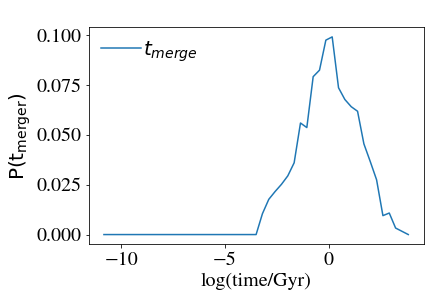

In [4]:
bound_factor = np.sum(bound)/float(size)  # fraction of systems that ended up bound post SN

# make histogram showing timescales
hist, bin_edges  = np.histogram(np.log10(t_merge/(c.yr*1e9)), bins=np.linspace(-11,4, 50),normed=True)
bin_center = (bin_edges[1:] + bin_edges[:-1])/2.

plt.plot(bin_center,hist*bound_factor,label=r'$t_{merge}$')

plt.xlabel('log(time/Gyr)')
plt.ylabel(r'$\rm P(t_{merger})$')
plt.legend()




# Merger timw for Maxwellian kick destribution

In [11]:
##### start system
n = 1000  # for range of separations
# a_initial = np.linspace(1.1,2.8,n)*c.rsun
a_initial = np.ones(n)*1.4*c.rsun
M1 = 5.4*c.msun
M2 = 1.3*c.msun
M_initial = M1+M2
v_orb = np.sqrt(c.G*M_initial/a_initial)

# kick and mass loss
M1_final = 2.1*c.msun

# maxwellian kick magnitude for number of tests for each separation
size = 10000
sigma = 30.0 #km/s


# funky variables used to calculate post SN orbits
beta = (M_initial - (M1 - M1_final))/(M_initial) # (mtotal-dm)/mtotal 
dm = (1.-beta)*M_initial



bounds_sigma  = np.zeros(1)
t_merges_sigma  = np.zeros(1)

for i in range(len(a_initial)):

   
    bound,t_merge = doSN_maxwellian(a_initial[i],sigma)
    
    bounds_sigma = np.append(bounds_sigma,bound)
    t_merges_sigma = np.append(t_merges_sigma,t_merge)
       
# t_merges = np.array(t_merges)
# bounds = np.array(bounds)




/Users/sophielundschroder/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:72: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


/Users/sophielundschroder/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/sophielundschroder/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  after removing the cwd from sys.path.


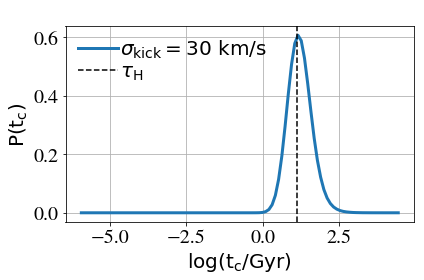

In [13]:

bound_factor = np.sum(bounds_sigma)/float(n*size)
# make histogram showing timescales
hist, bin_edges  = np.histogram(np.log10(t_merges_sigma[:]/(c.yr*1e9)), bins=np.linspace(-6,4.5, 100),normed=True)


bin_center = (bin_edges[1:] + bin_edges[:-1])/2.

plt.plot(bin_center,hist*bound_factor,lw=3,label=r'$\sigma_{\rm kick} =30\ {\rm km/s}$')

plt.axvline(x=np.log10(13.77),color='k',ls='--', label=r'$\tau_{\rm H}$')
plt.legend(loc='upper left')
plt.xlabel(r'$\rm log(t_{c}/Gyr)$')
plt.ylabel(r'$\rm P(t_{c})$')
plt.grid()
plt.tight_layout()
# plt.savefig('Mergertimes_maxwellian_30.pdf')

# print key numbers...

In [8]:
print "fraction of systems bound after SN ",bound_factor

fraction of systems bound after SN  0.3766036


In [9]:
merging = [t_merges_sigma[:]<13.77e9*c.yr]
print 'fraction of bound systems merging within Hubble time ', np.sum(merging)/np.sum(bounds_sigma)

fraction of bound systems merging within Hubble time  0.7948564485310283


In [22]:
percent975 = np.percentile(t_merges_sigma[:]/(c.yr*1e9),97.5)
percent25 = np.percentile(t_merges_sigma[:]/(c.yr*1e9),2.5)


print '95% interval in log space: ', np.log10(percent25), np.log10(percent975)
 
print '95% interval in Gyr:  ',percent25, percent975

95% interval in log space:  -2.543090910396968 2.3323290311168443
95% interval in Gyr:   0.002863578477359297 214.94583346346806


In [23]:
# save mergertimes in a txt file
np.savetxt("mergertimes.txt",t_merges_sigma[:]/(c.yr*1e9) , newline=" ")